# Load Libraries

In [373]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import nltk
import nltk.data
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Data

In [3]:
df = pd.read_csv('in.tsv', sep="\t", header=None, names = ['filename', 'keys', 'text_djvu', 'text_tesseract', 'text_textract', 'text_best'])

In [22]:
display(df.head())
print('Shape:', df.shape)
print('Type:\n', df.dtypes)

,filename,keys,text_djvu,text_tesseract,text_textract,text_best
0,008482cf51383c158b54e593cfa5fbf7.pdf,address__post_town address__postcode address__...,TAR\n1\nAugust 2016\nTrustees' Annual Report f...,CHARITY Trustees’' Annual Report for the perio...,CHARITY\nTrustees' Annual Report for the perio...,TAR\n1\nAugust 2016\nTrustees' Annual Report f...
1,009fab39d746267b6de8428366fe4b02.pdf,address__post_town address__postcode address__...,"\fAnnual Report 2015-2017 July, 2017\nStepping...",\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...,Charity Name\nNo lif anv)\nStepping Stone Thea...,\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...
2,01c7fd563327947c68abdd9717ef228d.pdf,address__post_town address__postcode address__...,Promoting Independent Living\nCelebrating new\...,54 S ke *\nB\n \nWelcome to our Annual\nReport...,Promoting Independent Living\nAbility\nAbility...,54 S ke *\nB\n \nWelcome to our Annual\nReport...
3,01d804edf76bec4912d2466908a60889.pdf,address__post_town address__postcode address__...,Annual Repor t 8\nAccounts 2017/18\nYear ended...,Annual Report &\nAccounts 2017//183\nYear ende...,Annua Report &\nAccounts 2017/18\nYear ended 3...,Annual Repor t 8\nAccounts 2017/18\nYear ended...
4,01e4461b059e707b7d8276b3d2b80b71.pdf,address__post_town address__postcode address__...,"The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb..."


Shape: (1729, 6)
Type:
 filename          object
keys              object
text_djvu         object
text_tesseract    object
text_textract     object
text_best         object
dtype: object


# Data Preprocessing

In [24]:
# Drop NaN values
df.dropna(inplace=True)

In [249]:
df.shape

(1683, 6)

In [44]:
df = df.replace(r'\\n',' ', regex=True)
df = df.replace(r'[^\w\s]',' ', regex=True)
df = df.replace(r'<.*?>',' ', regex=True)
df = df.replace(r'\[[^]]*\]',' ', regex=True)

In [40]:
# Cleaning text and lower casing all words
for char in '_-.,\n':
    df['text_textract'] = df['text_textract'].replace(char,' ')
df['text_textract'] = df['text_textract'].str.lower()

In [36]:
df['text_textract']

0       charity trustees' annual report for the period...
1       charity name no lif anv) stepping stone theatr...
2       promoting independent living ability ability a...
3       annua report & accounts 2017/18 year ended 31 ...
4       the greenway centre (registered charity, numbe...
                              ...                        
1724    charity trustees' annual report for the period...
1725    the gordon russell trust charity no. 326446 tr...
1726    friends of ezra charity no charity (if any) 11...
1727    caspari foundation (company number 3815700) (r...
1728    registered company number: 09623674 (england a...
Name: text_textract, Length: 1683, dtype: object

In [46]:
#df.loc[:, ["text_textract"]].iloc[1682].values

--------------------------------------------------------
#### OCR-ed documents transformed by Tesseract 
(meaning both new and old OCR engines were used simultaneously, and language and pixel density were forced for better results)


# Word Count

In [47]:
word_count = df['text_textract'].str.split(expand=True).stack().value_counts()

In [50]:
print('Word Count:\n', word_count)

Word Count:
 the        652215
and        328590
of         328408
to         250560
in         180471
            ...  
cotth           1
snitch          1
34760           1
cmdy            1
ooooddc         1
Length: 91587, dtype: int64


# Stemmimg and Tokenization

In [51]:
# Load english stop words
stopwords = nltk.corpus.stopwords.words('english')

In [52]:
# Load nltk's SnowballStemmer as variable 'stemmer'
stemmer = SnowballStemmer("english")

In [53]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# TF-IDFVectorizer

 ----------------------
 =>With Tfidfvectorizer, you will do all three steps at once. 
 - Under the hood, it computes the word counts, IDF values, and TF-IDF scores all using the same dataset.
 ---------------

In [54]:
# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

# TF-IDF Matrix

In [55]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_textract'])

/home/becode/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [57]:
print('TF-IDF Matrix shape:\n', tfidf_matrix.shape)
print('TF-IDF Matrix type:\n', type(tfidf_matrix))

TF-IDF Matrix shape:
 (1683, 2166)
TF-IDF Matrix type:
 <class 'scipy.sparse.csr.csr_matrix'>


### Pairwise_similarity

In [371]:
pairwise_similarity = tfidf_matrix * tfidf_matrix.T
pairwise_similarity

<1683x1683 sparse matrix of type '<class 'numpy.float64'>'
	with 2832489 stored elements in Compressed Sparse Row format>

### Cosine Similarity

In [375]:
cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)

array([[1.        , 0.32983187, 0.11217933, ..., 0.39337057, 0.27175079,
        0.18494628]])

### Features names

In [60]:
terms = tfidf_vectorizer.get_feature_names()
#print(terms)

# K-Means

-----------------
=> In practice, the k-means algorithm is very fast (one of the fastest clustering algorithms available), but it falls in local minima. That’s why it can be useful to restart it several times.


### Elbew Method

inertia_float
Sum of squared distances of samples to their closest cluster center.

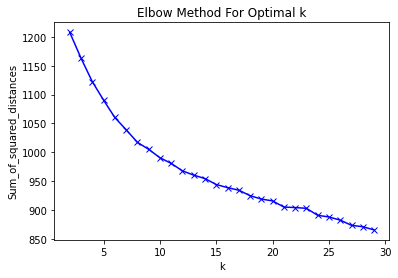

In [61]:
Sum_of_squared_distances = []
K = range(2,30)

for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=200, n_init=10)
    kmeans = kmeans.fit(tfidf_matrix)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### k=8

#### ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 

In [ ]:
k = 8
X = tfidf_matrix.toarray()

In [83]:
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=400, n_init=20)
kmeans.fit(tfidf_matrix)#Learn the idf vector

In [86]:
y = kmeans.predict(X)

In [ ]:
labels = kmeans.labels_.tolist()
print('Labels:\n',labels)

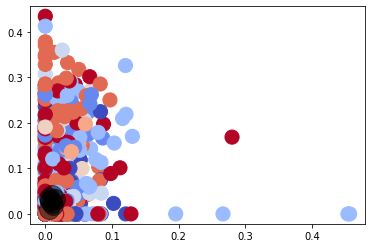

In [117]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=200, cmap='coolwarm')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=400, alpha=0.5)

In [ ]:
df['labels'] = list(labels)

In [85]:
df_cl = pd.DataFrame(list(zip(df['filename'],labels)),columns = ['filename','cluster'])
print(df_cl.sort_values(by = ['cluster']))

                                  filename  cluster
362   335fee4e94532ccb3b8e245ddad1f63a pdf        0
1028  97f7db448093deb2835d6222319f7ab0 pdf        0
525   4aba73764d57d5ed9d930c029ce59a2b pdf        0
1449  dcb020106dc0aee55efd58715a502b73 pdf        0
1033  98c23700d1fa72a2501413686351895d pdf        0
...                                    ...      ...
475   434d8cbd69ce66562de57ea08f7dabc3 pdf        7
586   54191d47151386fc07b7ea3a206e6629 pdf        7
1615  f3517f4df60d9d78214d45400f3f3f71 pdf        7
1376  d00a400741e182bc2a41c0b9b7e511d1 pdf        7
1227  b9063cd6254c6c0b0fdb4f1cd3d9e024 pdf        7

[1683 rows x 2 columns]


In [ ]:
#pca = PCA(n_components=k).fit(X)
#KM = KMeans(n_clusters=k, init=pca.components_, max_iter=400, n_init=1)

-----------------------------------
Fits transformer to X and y returns a transformed version of X.

X_new: ndarray array of shape (n_samples, n_features_new)
-->Transformed array.
----------------

#### ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.

In [310]:
k = 10
X = tfidf_matrix.toarray()

KM = KMeans(n_clusters=k, init='random', max_iter=1000, n_init=20)

%time
#Compute k-means clustering.
KM.fit(tfidf_matrix)

%time
# Predict the closest cluster each sample in X belongs to.
y = KM.predict(tfidf_matrix)

%time
# Compute clustering and transform X to cluster-distance space. 
# Fit to data, then transform it.
X_new = KM.fit_transform(tfidf_matrix)

labels = KM.labels_.tolist()
#print('Labels:\n',labels)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


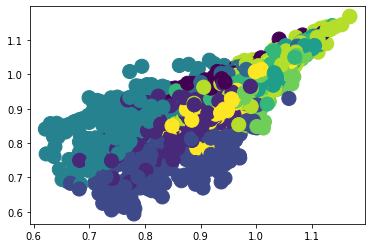

In [308]:
plt.scatter(X_new[:, 8], X_new[:, 4], c=y, s=200, cmap='viridis')

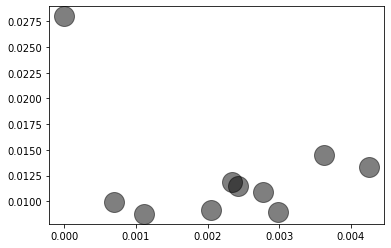

In [309]:
centers = KM.cluster_centers_
plt.scatter(centers[:, 8], centers[:, 4], c='black', s=400, alpha=0.5)

In [277]:
df['labels'] = list(labels)

In [279]:
df['labels'].value_counts()

3    388
0    366
4    299
6    239
7    123
5    120
2    103
1     45
Name: labels, dtype: int64

In [281]:
#df[df['labels'] == 1 ]

In [182]:
#df.loc[:, ["text_textract"]].iloc[658].values

## Word Cloud

Cluster: 0


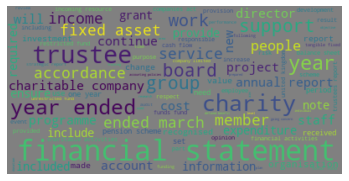

Cluster: 1


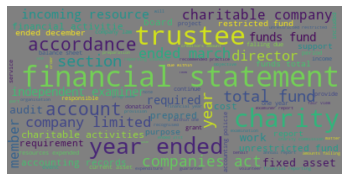

Cluster: 2


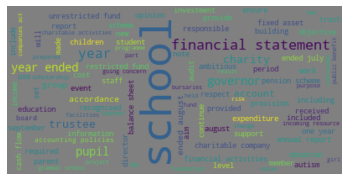

Cluster: 3


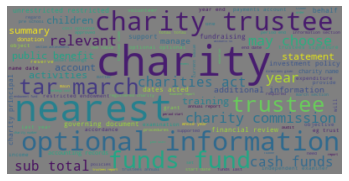

Cluster: 4


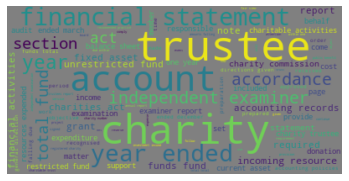

Cluster: 5


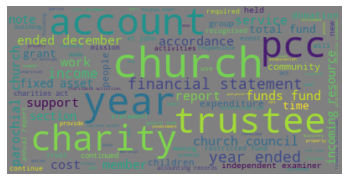

Cluster: 6


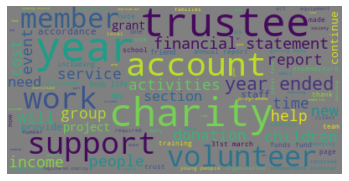

Cluster: 7


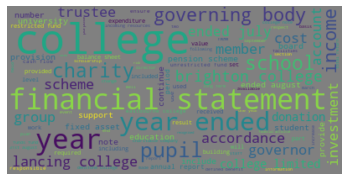

In [169]:
from wordcloud import WordCloud
result={'cluster':labels,'pdf':df['text_textract']}
result=pd.DataFrame(result)
for k in range(0,k):
    s=result[result.cluster==k]
    text=s['pdf'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="grey").generate(text)
    print('Cluster: {}'.format(k))
    #print('Titles')
    titles=df_cl[df_cl.cluster==k]['filename']         
    #print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# DBSCAN

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

In [260]:
# Define dataset
X = tfidf_matrix.toarray()

# Define the model
db = DBSCAN(eps=0.4, min_samples=5, metric='euclidean', algorithm='ball_tree', leaf_size=30).fit(X)

Estimated number of clusters: 18
Estimated number of noise points: 1577


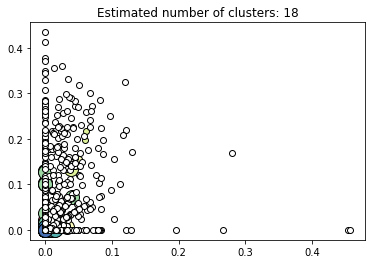

In [261]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [1, 1, 1, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [269]:
df['labels'] = list(labels)

In [270]:
df['labels'].value_counts()

-1     1577
 1       17
 9        9
 7        5
 0        5
 2        5
 3        5
 4        5
 5        5
 6        5
 16       5
 15       5
 17       5
 10       5
 11       5
 12       5
 13       5
 14       5
 8        5
Name: labels, dtype: int64

In [272]:
df[df['labels']==7]

,filename,keys,text_djvu,text_tesseract,text_textract,text_best,labels
273,25ef7f0d940e51cf00b61869e7f702d8 pdf,address__post_town address__postcode address__...,BRIGHTONWESTDIVISIONGUIDES ANNUALREPORTFORTHEY...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,brighton west division guides annual report fo...,BRIGHTONWESTDIVISIONGUIDES ANNUALREPORTFORTHEY...,7
795,71bdbd1916d460617f5f5a1b7158d651 pdf,address__post_town address__postcode address__...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,brighton west division guides annual report fo...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,7
1212,b03732b0d7414ef7604f442b5752c501 pdf,address__post_town address__postcode address__...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,brighton west division guides annual report fo...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,7
1543,e3aee543b9cd1311eccdf6d82b109eda pdf,address__post_town address__postcode address__...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,brighton west division guides annual report fo...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,7
1589,e9532f4f698b3e518dbf311e075b3695 pdf,address__post_town address__postcode address__...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,brighton west division guides annual report fo...,BRIGHTON WEST DIVISION GUIDES ANNUAL REPORT FO...,7


In [273]:
df[df['labels']==0]

,filename,keys,text_djvu,text_tesseract,text_textract,text_best,labels
14,030d80fea4fc1ac8d3d8f366ec92bd21 pdf,address__post_town address__postcode address__...,Charity Registered No r083995 Company Registe...,METHODIST HOMES PORT AND ACCOUNTS 31 March...,charity first 8 sep 20m accounes recenved met...,Charity Registered No r083995 Company Registe...,0
462,401026f1b90e03bddca32972d47a1b94 pdf,address__post_town address__postcode address__...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,methodist homes report and financial statement...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,0
598,530352185b91c7876cdc99f5c9fa1344 pdf,address__post_town address__postcode address__...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,methodist homes report and financial statement...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,0
1369,c93ab85fbaa95a2a4ad0ccb51e1d0196 pdf,address__post_town address__postcode address__...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,methodist homes report and financial statement...,METHODIST HOMES REPORT AND FINANCIAL STATEMENT...,0
1704,fc2ee8284700d4fa58925ef83af8cf73 pdf,address__post_town address__postcode address__...,1 D H z c D D r r L r L O j Z H H ...,S B R R R METHODIST HOMES REPORT AND ACCOUNT...,methodist homes report and accounts 31 march 2...,1 D H z c D D r r L r L O j Z H H ...,0


In [274]:
df[df['labels']==2]

,filename,keys,text_djvu,text_tesseract,text_textract,text_best,labels
71,0aac0eba00811f0552259efcbdc9234d pdf,address__post_town address__postcode address__...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,company number 3752751 charity number 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,2
938,85c3b1b1b914c49fb67e8b0b58ea16fe pdf,address__post_town address__postcode address__...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,company number 3752751 charity number 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,2
1449,d5208563d1d6b6f4c186ecfa06a4dfe3 pdf,address__post_town address__postcode address__...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,S CALICO HOMES LIMITED Report and Financial St...,company number 3752751 charity number 115194...,S CALICO HOMES LIMITED Report and Financial St...,2
1558,e4f98ba78a6d3334b53785a537128638 pdf,address__post_town address__postcode address__...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115198...,company number 3752751 charity number 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,2
1679,f691f1cc66ea7288e3cf7a233fc793f2 pdf,address__post_town address__postcode address__...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,company number 3752751 charity number 115194...,COMPANY NUMBER 3752751 CHARITY NUMBER 115194...,2


In [275]:
df[df['labels']==9]

,filename,keys,text_djvu,text_tesseract,text_textract,text_best,labels
353,3162e7993554acd7fb45eaf96d549e43 pdf,address__post_town address__postcode address__...,Charity Registration No 1102588 Company Regis...,Charity Registration No 1102588 Company Regis...,charity registration no 1102588 company regis...,Charity Registration No 1102588 Company Regis...,9
430,3bc8da7d893b2b861036b0342caefb26 pdf,address__post_town address__postcode address__...,Ec PW Charity Registration t4o 1076483 Compa...,Charity Registration No 1076483 Company Regis...,extenal charity registration no 1076483 compa...,Ec PW Charity Registration t4o 1076483 Compa...,9
449,3deb2ad3880982e86fb3b672b930a7e2 pdf,address__post_town address__postcode address__...,Charity Registration No 1076483 Company Regis...,Charity Registration No 1076483 Company Regis...,charity registration no 1076483 company regis...,Charity Registration No 1076483 Company Regis...,9
980,8b5d842d702fc464643162e387b152f6 pdf,address__post_town address__postcode address__...,Charity Registration N Company Registration No...,Charity Registration No 1102538 Company Re...,charity registration no 1102588 company regis...,Charity Registration N Company Registration No...,9
1208,afde656c306d7125611bc9755b9a9116 pdf,address__post_town address__postcode address__...,Charity Registration No 1076483 Company Regis...,Charity Registration No 1076483 Company Regis...,charity registration no 1076483 company regis...,Charity Registration No 1076483 Company Regis...,9
1260,b9063cd6254c6c0b0fdb4f1cd3d9e024 pdf,address__post_town address__postcode address__...,Charity Registration No U 76483 Company Regis...,CHan vy comMt tya Charity Registration No 107...,chanty connimta charity registration no 10764...,Charity Registration No U 76483 Company Regis...,9
1437,d324272fbe15179003fed9c634e68086 pdf,address__post_town address__postcode address__...,Charity Registration No 1102588 Company Regis...,Charity Registration No 1102588 Company Regis...,charity registration no 1102588 company regis...,Charity Registration No 1102588 Company Regis...,9
1588,e94807c9f87166b963e1cfa27ccd930b pdf,address__post_town address__postcode address__...,Charity Registration No 1076483 Company Regis...,Charity Registration No 1076483 Company Regis...,charity registration no 1076483 company regis...,Charity Registration No 1076483 Company Regis...,9
1626,ee34f8ebc2902e5e15daa22b97c0305b pdf,address__post_town address__postcode address__...,Charity Registration No 1102588 Company Regis...,Charity Registration No 1102588 Company Regis...,charity registration no 1102588 company regis...,Charity Registration No 1102588 Company Regis...,9


# HDBSCAN

In [312]:
import hdbscan

In [327]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [340]:
hdb = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True, gen_min_span_tree=False, leaf_size=40)

In [341]:
X = tfidf_matrix.toarray()

hdb.fit(tfidf_matrix)

print('Labels:\n', hdb.labels_)
print('Largest cluster label:\n', hdb.labels_.max())
print(hdb.probabilities_)

HDBSCAN()

In [336]:
#HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True, gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None), metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

In [346]:
distance_matrix = pairwise_distances(tfidf_matrix)
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distance_matrix)
clusterer.labels_

array([ 7, -1, -1, ..., 10,  4, -1])

In [364]:
hdb = hdbscan.HDBSCAN(min_cluster_size=15).fit(tfidf_matrix)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, hdb.probabilities_)]
plt.scatter(*tfidf_matrix.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

IndexError: list index out of range

In [361]:
hdb.condensed_tree_

<AxesSubplot:ylabel='$\\lambda$ value'>

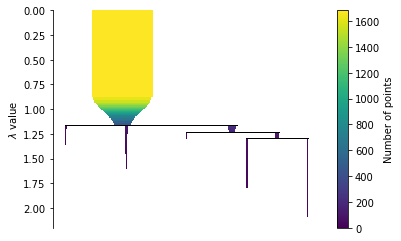

In [362]:
hdb.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

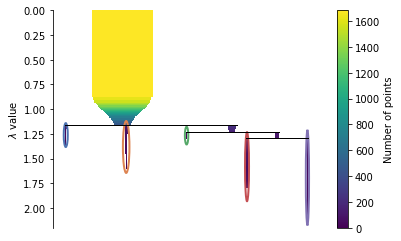

In [369]:
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 20))

=> We can now see the hierarchy as a dendrogram, the width (and color) of each branch representing the number of points in the cluster at that level. 

<AxesSubplot:ylabel='distance'>

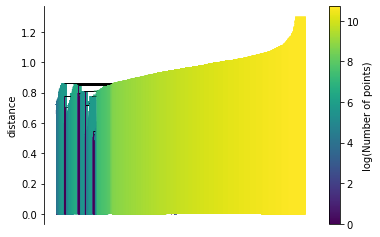

In [367]:
hdb.single_linkage_tree_.plot()